https://github.com/caelanreid/PatternFlow/tree/topic-recognition/recognition/42936127
^REPO


VQVAE Implementation adapted from this tutorial from keras https://keras.io/examples/generative/vq_vae/


In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
seed = 123
batch_size = 64
img_height = 256
img_width = 256
image_shape = (img_height, img_width, 3)

from modules import *
from tools import *


from modules import VectorQuantizer 

from dataset import train_ds, val_ds, train_variance


vqvae_trainer = VQVAETrainer(train_variance, latent_dim=16, num_embeddings=64, image_shape = image_shape)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(
    x = train_ds,
    validation_data = val_ds,
    epochs = 5,
    batch_size = 128,
    use_multiprocessing = True,
    verbose = 1
)
vqvae_trainer.vqvae.save("saved_models")
vqvae = vqvae_trainer.vqvae
print("trained and saved model")

/home/caelan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 11328 files belonging to 1 classes.
Using 7930 files for training.
Using 3398 files for validation.
Epoch 1/5
248/248 [==============================] - 23s 82ms/step - loss: 64.8269 - reconstruction_loss: 0.5778 - vqvae_loss: 63.8151 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss: 0.0000e+00
Epoch 2/5
248/248 [==============================] - 20s 80ms/step - loss: 6.1006 - reconstruction_loss: 0.2419 - vqvae_loss: 5.8532 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss: 0.0000e+00
Epoch 3/5
248/248 [==============================] - 20s 79ms/step - loss: 3.5814 - reconstruction_loss: 0.1231 - vqvae_loss: 3.4319 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss: 0.0000e+00
Epoch 4/5
248/248 [==============================] - 20s 79ms/step - loss: 0.3213 - reconstruction_loss: 0.0717 - vqvae_loss: 0.2478 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_vq_loss:

INFO:tensorflow:Assets written to: saved_models/assets


INFO:tensorflow:Assets written to: saved_models/assets


trained and saved model


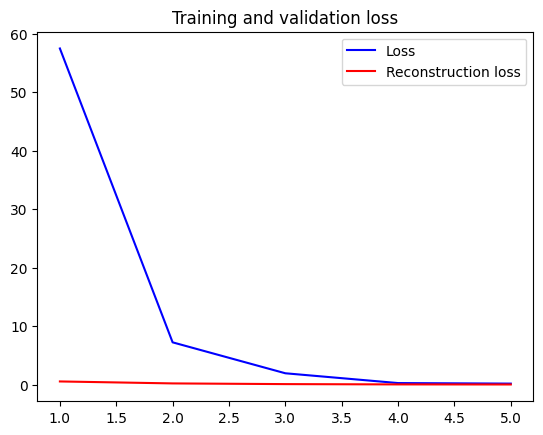

In [2]:
show_history(history.history)

In [ ]:
history = vqvae_trainer.fit(
    x = train_ds,
    validation_data = val_ds,
    epochs = 3,
    use_multiprocessing = True,
    verbose = 1
)
vqvae_trainer.vqvae.save("saved_models")
show_history(history.history)

# Visualize reconstruction

1/1 [==============================] - 0s 109ms/step
(32, 256, 256, 3)
(256, 256, 3)
(256, 3)
(3,)
original.shape (256, 256, 3)


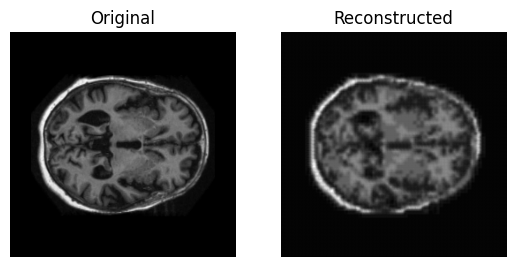

In [3]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython import display


test_images = val_ds.take(1)
reconstructed_test_images = vqvae.predict(test_images)

len(reconstructed_test_images)

for test_image, reconstructed_image in zip(test_images, reconstructed_test_images):
    print(test_image.shape)
    print(test_image[0].shape)
    print(test_image[0][0].shape)
    print(test_image[0][0][0].shape)

    show_original_vs_reconstructed(test_image[1],reconstructed_test_images[1])

# fig, ax = plt.subplots()
# def animate(i):
#     ax.clear()
#     plt.imshow(reconstructed_test_images[i], cmap="gray")
#     plt.axis("off")
    
# anim = FuncAnimation(fig, animate, 
#     frames = len(reconstructed_test_images),
#     blit = False,
#     repeat = True,
#     interval = 200
# )
# from IPython.display import HTML
# HTML(anim.to_html5_video())

1/1 [==============================] - 0s 276ms/step


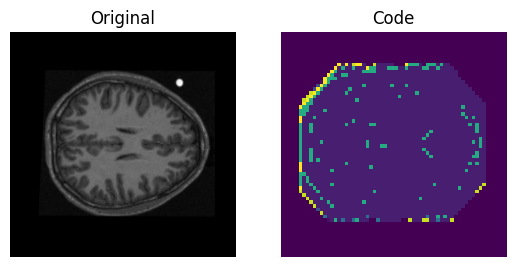

In [4]:



encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for test_image, reconstructed_image in zip(test_images, reconstructed_test_images):
    test_image = test_image[10]
    reconstructed_image = reconstructed_image[10]

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_image / 255.0)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()


In [5]:
encoded_outputs.shape

(32, 64, 64, 16)

In [10]:
encoded_outputs.shape[1:-1]

(64, 64)

In [6]:
# PixelCNN hyperparameters
num_residual_blocks = 1
num_pixelcnn_layers = 1
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()



Input shape of the PixelCNN: (64, 64)
Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64)]          0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 64, 64, 64)        0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 64, 64, 128)      401536    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 64, 64, 128)      98624     
 ck)                                                             
                                                                 
 pixel_conv_layer_2 (PixelCo  (None, 64, 64, 128)      16512     
 nvLayer)                                                        
                   

In [7]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


In [13]:
encoded_outputs = encoder.predict(train_ds.take(10))
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

10/10 [==============================] - 0s 10ms/step
Shape of the training data for PixelCNN: (320, 64, 64)


In [14]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=32,
    epochs=30,
    validation_split=0.1,
)
pixel_cnn.save("saved_models/pixelcnn/")

Epoch 1/30
9/9 [==============================] - 2s 70ms/step - loss: 0.3729 - accuracy: 0.9257 - val_loss: 0.3332 - val_accuracy: 0.9319
Epoch 2/30
9/9 [==============================] - 0s 46ms/step - loss: 0.3057 - accuracy: 0.9345 - val_loss: 0.2762 - val_accuracy: 0.9375
Epoch 3/30
9/9 [==============================] - 0s 46ms/step - loss: 0.2556 - accuracy: 0.9403 - val_loss: 0.2339 - val_accuracy: 0.9438
Epoch 4/30
9/9 [==============================] - 0s 46ms/step - loss: 0.2196 - accuracy: 0.9452 - val_loss: 0.2067 - val_accuracy: 0.9471
Epoch 5/30
9/9 [==============================] - 0s 45ms/step - loss: 0.1980 - accuracy: 0.9474 - val_loss: 0.1909 - val_accuracy: 0.9474
Epoch 6/30
9/9 [==============================] - 0s 45ms/step - loss: 0.1855 - accuracy: 0.9476 - val_loss: 0.1823 - val_accuracy: 0.9480
Epoch 7/30
9/9 [==============================] - 0s 46ms/step - loss: 0.1785 - accuracy: 0.9483 - val_loss: 0.1769 - val_accuracy: 0.9496
Epoch 8/30
9/9 [===========

INFO:tensorflow:Assets written to: saved_models/pixelcnn/assets


INFO:tensorflow:Assets written to: saved_models/pixelcnn/assets


In [15]:
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [16]:

batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors, verbose = 0)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")


Prior shape: (10, 64, 64)


1/1 [==============================] - 0s 16ms/step


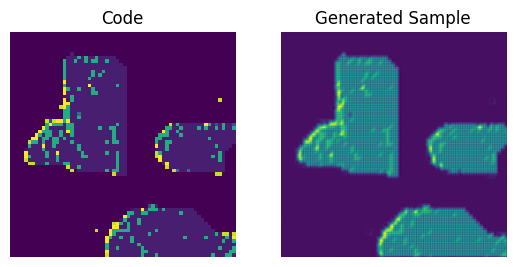

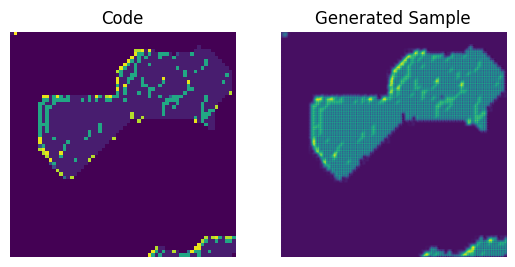

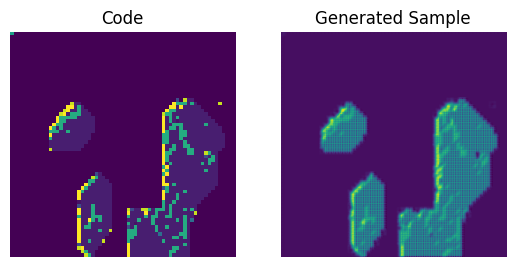

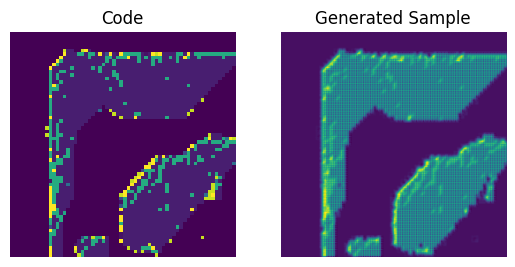

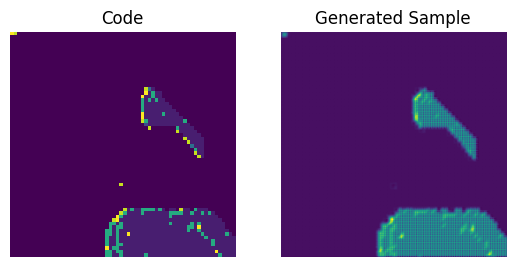

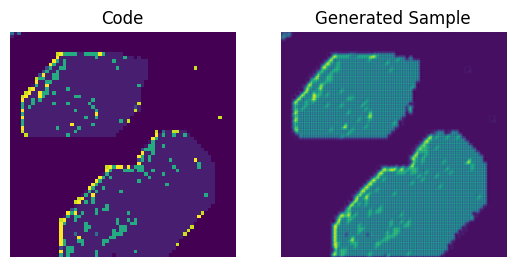

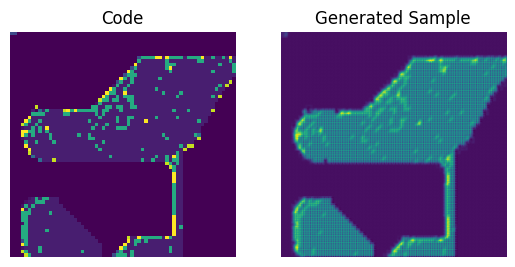

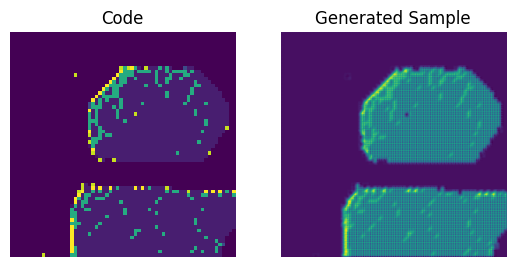

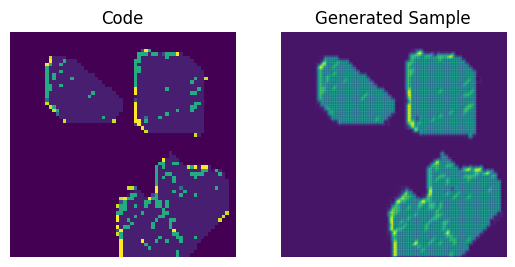

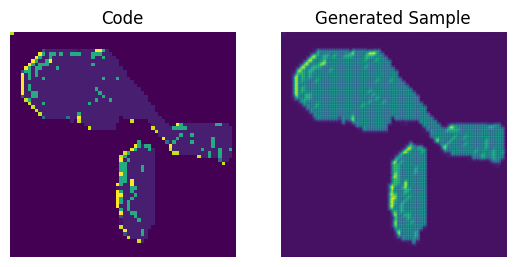

In [17]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()
